# A Notebook for Fitting Classification Models on the Data

We are loading the tagged set of charging stations and the features we have extracted from the data. We are going to fit a number of classification models on the data and evaluate their performance.

Finally, we train a Random Forest classifier with weight attached as per cluster allocations and their "confidence level" in the cluster.

Cluster selection is simple, we are using a "majority vote" for picking the right one.

In [1]:
# Using pathlib for proper path management
from pathlib import Path

# Data manipulation
import pandas as pd
import geopandas as gpd


# Optimised data storage
import pyarrow.feather as feather

# Classification models and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import randint

# Graphs and visualisation (and GeoJSON border handling)
import plotly.express as px
import json

# Images in notebooks (for GitHub publishing)
from IPython.display import Image

## Loading data and checking some simple statistics

In [2]:
charging_stations = gpd.read_feather(Path.joinpath(Path.cwd(), 'data', 'NETWORK_OPERATOR', 'Charging stations with clusters.feather'))

In [3]:
charging_stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5194 entries, 0 to 5193
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   evse_id                 5194 non-null   object  
 1   latitude                5194 non-null   float64 
 2   longitude               5194 non-null   float64 
 3   zip code                5192 non-null   object  
 4   town                    5192 non-null   object  
 5   geometry                5194 non-null   geometry
 6   amenity_osm_id          1204 non-null   float64 
 7   amenity_latitude        1204 non-null   float64 
 8   amenity_longitude       1204 non-null   float64 
 9   amenity                 1204 non-null   object  
 10  amenity_distance        1204 non-null   float64 
 11  landuse_osm_id          3706 non-null   object  
 12  landuse_fclass          3706 non-null   object  
 13  reverse_osm_id          5194 non-null   int64   
 14  reverse_osm_type

In [4]:
# Some descriptive stats show that we need to do something and scale the data
charging_stations.describe()

,latitude,longitude,amenity_osm_id,amenity_latitude,amenity_longitude,amenity_distance,reverse_osm_id,amenities_near,charging_capacity_near,0,1,2,3,4,cluster,cluster_weight
count,5194.000000,5194.000000,1.204000e+03,1204.000000,1204.000000,1204.000000,5.194000e+03,5194.000000,5194.000000,5194.000000,5194.000000,5194.000000,5194.0,5194.000000,5194.000000,5194.000000
mean,50.990976,4.267569,8.738903e+09,50.994234,4.247474,14.689394,1.048226e+09,4.791875,0.769927,3.198498,0.987678,2.905468,0.0,1.749326,1.220254,0.816672
std,0.221271,0.661869,1.762324e+09,0.224635,0.734373,13.228980,2.086496e+09,11.555191,3.212485,9.986206,3.824305,11.779888,0.0,10.967782,1.215475,0.216785
min,49.647490,2.565576,2.573745e+08,50.007894,2.612807,0.000000,1.180890e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.250000
25%,50.868001,3.807334,7.863655e+09,50.868621,3.713300,3.736100,1.589733e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.625000
50%,51.017241,4.399353,9.195628e+09,51.005703,4.395642,9.914809,3.766789e+08,2.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,1.000000
75%,51.159463,4.626479,9.929423e+09,51.158539,4.723971,23.081299,8.355956e+08,5.000000,0.000000,2.000000,0.000000,2.000000,0.0,0.000000,2.000000,1.000000
max,51.464078,6.206937,1.116421e+10,51.464072,6.118834,49.687727,1.106998e+10,159.000000,70.000000,217.000000,76.000000,266.000000,0.0,272.000000,4.000000,1.000000


In [5]:
# A sample of the records
charging_stations.drop(columns=['evse_id', 'latitude', 'longitude', 'town']).sample(5, random_state=42)

,zip code,geometry,amenity_osm_id,amenity_latitude,amenity_longitude,amenity,amenity_distance,landuse_osm_id,landuse_fclass,reverse_osm_id,...,reverse_type,amenities_near,charging_capacity_near,0,1,2,3,4,cluster,cluster_weight
3547,3630,POINT (5.69473 50.95438),9.820766e+09,50.954381,5.694728,charging_station,0.000000,None,None,359664371,...,parking,3,1,1,1,1,0,0,0,0.333333
79,7000,POINT (3.97523 50.45654),NaN,NaN,NaN,None,NaN,56463602,residential,4176522401,...,supermarket,15,0,1,0,0,0,0,0,1.000000
4784,2900,POINT (4.47577 51.23902),NaN,NaN,NaN,None,NaN,23400676,industrial,150182822,...,yes,0,0,1,0,1,0,0,0,0.500000
4444,2160,POINT (4.49091 51.20626),NaN,NaN,NaN,None,NaN,626481706,residential,387738913,...,house,6,0,0,0,1,0,0,2,1.000000
4295,8301,POINT (3.27327 51.34329),8.626741e+09,51.343380,3.273594,charging_station,24.677749,884209645,park,8626741441,...,charging_station,7,1,2,0,0,0,0,0,1.000000


What kind of landuse classes do we have in the set?

In [6]:
charging_stations['landuse_fclass'].value_counts()

landuse_fclass
residential          2294
industrial            695
commercial            270
retail                203
grass                  66
forest                 48
park                   42
meadow                 33
recreation_ground      23
farmland               11
nature_reserve          7
farmyard                7
scrub                   4
quarry                  2
heath                   1
Name: count, dtype: int64

## Performing classification

Initially, we need to add the features based on the interpretation of clustering.

Additionally, we "translate" information on tags collected during the "tagging" phase as well and feed these as features to the classifier.

### Setting the target variable

In [7]:
# We treat clusters 0, 1 as commercial type of use
charging_stations['is_commercial'] = charging_stations.apply(lambda x: 1 if x['cluster'] in (0, 1) else 0, axis=1)
# We treat clusters 2, 4 as residential type of use
charging_stations['is_residential'] = charging_stations.apply(lambda x: 1 if x['cluster'] in (2, 4) else 0, axis=1)

### Setting up features used for training

In [8]:
# The following are the reverse lookup types that we consider as commercial or residential
REVERSE_TYPES_COMMERCIAL = ('parking', 'charging_station', 'supermarket', 'car_sharing', 'services', 'car', 'hotel', 'hospial', 'school')
REVERSE_TYPES_RESIDENTIAL = ('house', 'residential', 'apartments')
# Let's set the features accordingly
charging_stations['is_reverse_commercial'] = charging_stations.apply(lambda x: 1 if x['reverse_type'] in (REVERSE_TYPES_COMMERCIAL) else 0, axis=1)
charging_stations['is_reverse_residential'] = charging_stations.apply(lambda x: 1 if x['reverse_type'] in (REVERSE_TYPES_RESIDENTIAL) else 0, axis=1)

# We are adding the landuse descriptive feature as well
charging_stations['is_landuse_commercial'] = charging_stations.apply(lambda x: 1 if x['landuse_fclass'] in ('industrial', 'commercial', 'retail') else 0, axis=1)

# A boolean feature to state if the station is a "known" charging point in the OpenStreetMap database or not
charging_stations['amenity_charging_station'] = charging_stations.apply(lambda x: 1 if x['amenity'] == 'charging_station' else 0, axis=1)   

# Okay, let's see how the data looks like now
charging_stations[['amenity_charging_station', 'is_commercial', 'cluster', 'reverse_type', 'is_reverse_commercial', 'is_reverse_residential', 'is_landuse_commercial']].sample(10, random_state=42)

,amenity_charging_station,is_commercial,cluster,reverse_type,is_reverse_commercial,is_reverse_residential,is_landuse_commercial
3547,1,1,0,parking,1,0,0
79,0,1,0,supermarket,1,0,0
4784,0,1,0,yes,0,0,1
4444,0,0,2,house,0,1,0
4295,1,1,0,charging_station,1,0,0
3583,1,0,2,parking,1,0,0
2174,0,0,2,house,0,1,0
2487,1,0,2,warehouse,0,0,1
721,1,1,0,parking,1,0,0
2110,0,0,4,yes,0,0,0


## Scaling

In [9]:
# These are the features the model will use
FEATURES = ['amenity_charging_station', 'amenities_near', 'charging_capacity_near', 'cluster_weight', 'is_reverse_commercial', 'is_reverse_residential', 'is_landuse_commercial']

# Our features and the target variable
X = charging_stations[FEATURES].copy()
y = charging_stations['is_residential']

X[FEATURES].sample(5, random_state=42)

,amenity_charging_station,amenities_near,charging_capacity_near,cluster_weight,is_reverse_commercial,is_reverse_residential,is_landuse_commercial
3547,1,3,1,0.333333,1,0,0
79,0,15,0,1.000000,1,0,0
4784,0,0,0,0.500000,0,0,1
4444,0,6,0,1.000000,0,1,0
4295,1,7,1,1.000000,1,0,0


In [10]:
# Scaling and normalizing the data

# We scale only the features that need it, for boolean values, we are not doing anything
FEATURES_TO_SCALE = ['amenities_near', 'charging_capacity_near']
X[FEATURES_TO_SCALE] = StandardScaler().fit_transform(X[FEATURES_TO_SCALE])

X.sample(5, random_state=42)


,amenity_charging_station,amenities_near,charging_capacity_near,cluster_weight,is_reverse_commercial,is_reverse_residential,is_landuse_commercial
3547,1,-0.155086,0.071625,0.333333,1,0,0
79,0,0.883508,-0.239690,1.000000,1,0,0
4784,0,-0.414735,-0.239690,0.500000,0,0,1
4444,0,0.104563,-0.239690,1.000000,0,1,0
4295,1,0.191112,0.071625,1.000000,1,0,0


### Fitting the model

We are splitting the data to training and validation sets (80/20), then start with checking classifiers followed by tuning the model.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We save the cluster weight for later use (for feeding the model, but not as features)
X_train_clusters = X_train['cluster_weight']
# Removing this variable from the training and test sets
X_train = X_train.drop(columns=['cluster_weight'])
y_train = y_train.drop(columns=['cluster_weight'])
X_test = X_test.drop(columns=['cluster_weight'])
y_test = y_test.drop(columns=['cluster_weight'])

Evaluating a few models and looking at the accuracy scores.

It is more for fun,a s we know that we go forward with a Weighted Random Forest classifier.

In [12]:
model = LogisticRegression(max_iter=1000)    # max_iter=1000 to avoid convergence warning
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

model = HistGradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

model = AdaBoostClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

model = RidgeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))#


0.5736284889316651
0.5640038498556305
0.5659287776708374
0.5736284889316651
0.5736284889316651


Now, we really fit the model. Actually, we already know the parameters we will use:

* n_estimators = 428
* max_depth = 4
* class_weight = "balanced_"
* bootstrap = False



0.591915303176131
Accuracy: 0.591915303176131 Precision: 0.5572005383580081 Recall: 0.8133595284872298


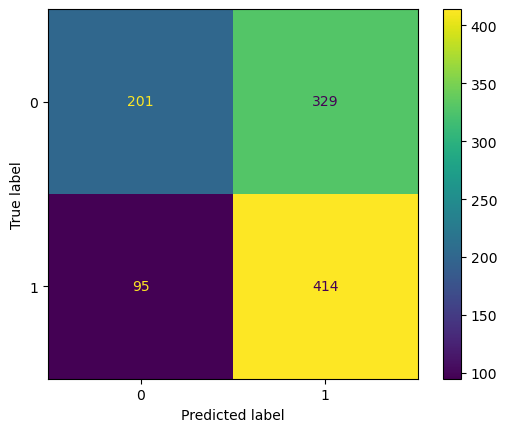

In [13]:
# We are using the save cluster weights as sample weights
sample_weights = X_train_clusters

# This is our final model
model = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=4, n_estimators=428,  bootstrap=False)

# Fitting the model with wights attached
model.fit(X_train, y_train, sample_weight=sample_weights)

# Predicting the test set
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

# Let's see the accuracy, precision and recall
accuracy = accuracy_score(y_test, y_pred)
precision_score = precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)
print(f"Accuracy: {accuracy} Precision: {precision_score} Recall: {recall_score}")

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Plotting the importance of features.

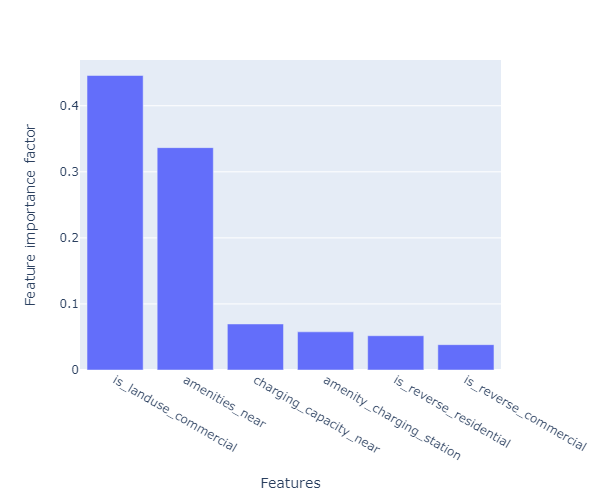

In [14]:
# Saving the importances reported by the model in a Series
feature_importances = pd.Series(
    model.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

# Plotting the feature importances
fig = px.bar(
    feature_importances,
    x=feature_importances.index,
    y=feature_importances.values,
    labels={
        "index": "Features",
        "y": "Feature importance factor",
    },
    width=600,
)

# fig.show()
# Instead of Plotly show() we can also take the bytes of the image and display it in the notebook directly using Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)

To be honest, it is not really important, but for fun, we can visualize some decision trees.
Let's do that...

Note: this will not be shown on GitHub

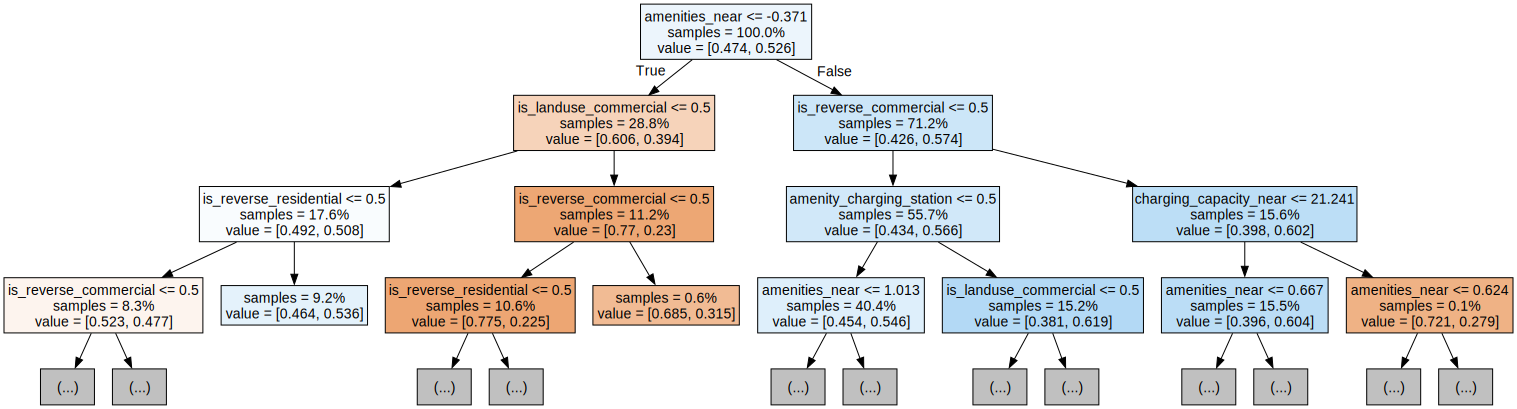

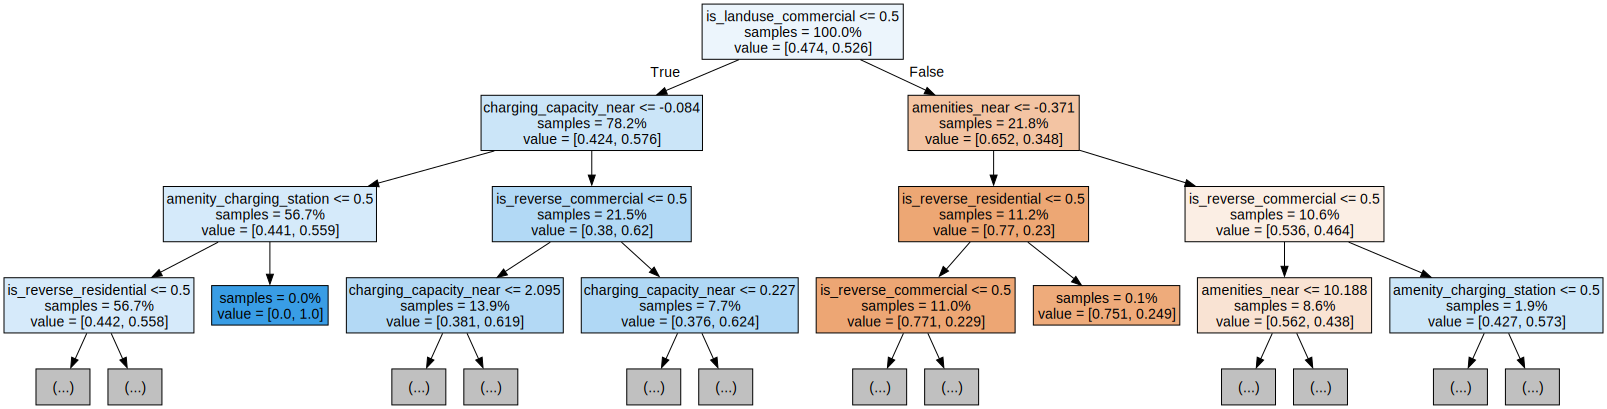

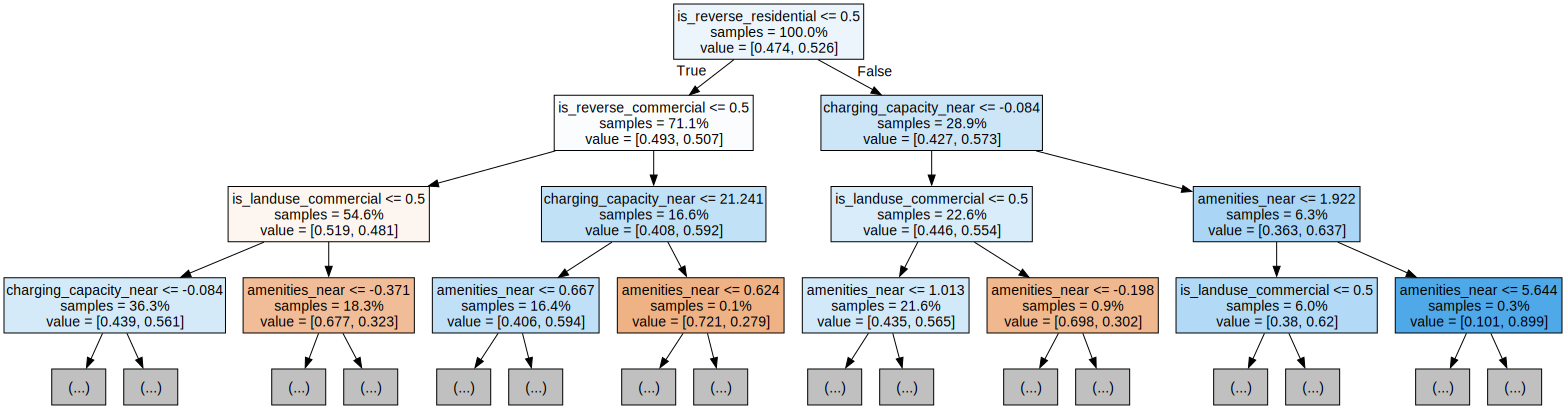

In [15]:
from sklearn.tree import export_graphviz
#from IPython.display import Image
import graphviz

# Let's look at three trees and with max_depth=3
for i in range(3):
    tree = model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


### Building a simple map with class predictions

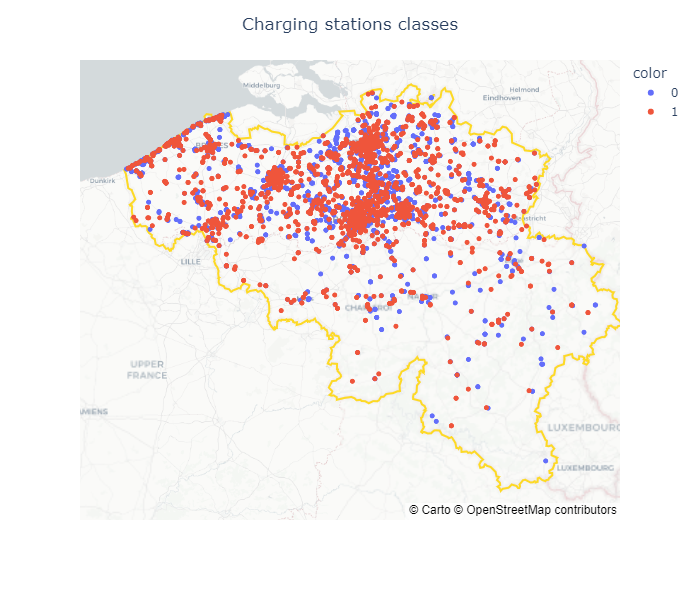

In [16]:
# Let's get the Belgian border from the EUROSTAT dataset
belgium_gdf = gpd.read_file(Path.joinpath(Path.cwd(), 'data', 'EUROSTAT-ref-countries-2020-01m-shp', 'CNTR_RG_01M_2020_4326', 'CNTR_RG_01M_2020_4326.shp'))
belgium_gdf = belgium_gdf[belgium_gdf['CNTR_ID'] == 'BE']

# And now the map
fig = px.scatter_mapbox(
    charging_stations,
    lat='latitude',
    lon='longitude',
    hover_name='evse_id',
    color=charging_stations['is_residential'].astype(str),
    center=dict(lat=50.5, lon=4.3),
    )

# Some map settings and adding a layer with the Belgian border
fig.update_layout(
    title = 'Charging stations classes',
    title_x = 0.5,
    mapbox={
                'style': 'carto-positron',
                'zoom': 6.5,

                'layers': [
                    # Belgian border
                    {
                        'sourcetype': 'geojson',
                        'source': json.loads(belgium_gdf.geometry.to_json()), # we need to use json.loads to convert the string to a proper Python dictionary
                        'below': 'traces',
                        'type': 'line',
                        'color': '#fdda24', # yellow of the Belgian flag
                        'line': {'width': 2.0},
                    }
                ],
            },
    paper_bgcolor='#ffffff',
    height=600
)

# fig.show()
# Instead of Plotly show() we can also take the bytes of the image and display it in the notebook directly using Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)

## Optimizing parameters of the RandomForest classifier

Before we fit the model, we had a look at the parameters of the classifier. We were using RandomizedSearchCV to find the best options over a wide range. 

In [17]:
# So, we set these ranges for the search
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
# Here, we are reusing our previously set model
#model = RandomForestClassifier()


# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(bootstrap=False,
                                                    class_weight='balanced',
                                                    max_depth=4,
                                                    n_estimators=428,
                                                    random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000015BB92C2550>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000015BB92C2C90>})

Once we have the best parameters, we can check the model again, and see what the accuracy score is for the test set.

Best hyperparameters: {'max_depth': 4, 'n_estimators': 272}
Accuracy: 0.5938402309913379 Precision: 0.5590230664857531 Recall: 0.8094302554027505


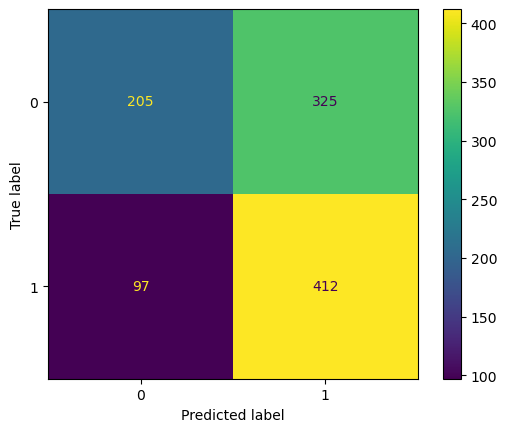

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score

#Create a variable for the best model
best_model = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)
# Generate predictions with the best model
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision_score = precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)
print(f"Accuracy: {accuracy} Precision: {precision_score} Recall: {recall_score}")

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();